In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns
import sys
import os

In [2]:
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path+"\\code")

from data_plot import cat_plot
from data_plot import cat_plot_y

In [3]:
data = pd.read_csv('../output_files/data.csv')

In [4]:
# change column types
obj_colnames = ['tnc_veh', 'delivery', 'county', 'region', 'charge_work', 'elec_acc', 'housing', 
                'hh_inc', 'gender', 'employ', 'stu', 'drive_freq', 'race']
int_colnames = ['ann_mile', 'hh_veh', 'hh_size','hh_emp','hh_drv']

for col in obj_colnames:
    data[col] = data[col].astype('object')
    
data['ann_mile'] = data['ann_mile'].astype('float64')   

## Analysis scope

The analysis in this project will focus on the 2019 residential light-duty California (CA) Vehicle Survey data collected by the California Energy Commision. The dataset contains information on both the household and personal level of the respondents. Each vehicle in a household is assigned to a main driver, a member of the household, by the survey respondent. The aim of our analysis will be to classify respondents/households according to the response variables below. For more information on the aim of our analysis, see the 'Performance' notebook.

## Response Variable

The dataset contains information on fuel sources for each vehicle the repondent is interviewed about. These range from standard gasoline fueled vehicles to battery electric vehicles. For the purpose of our analysis we group each vehicle into one of two types: EV or ICEV.

__Powertrain types:__
* Electric Vehicle (EV): battery electric vehicle, plug in hybrid electric vehicle, fuel cell electric vehicle 
* Internal Combustion Engine Vehicle (ICEV): gasoline, diesel, E85

## Nature of the Data and Initial Exploratory Analysis

This survey was a stratified random sample of both electric and standard fuel vehicles, ensuring that the data represents the CA market. As a result, the vehicle types are moderately imbalanced, with EV types vehicles comprising approximately 10.7% of all light-duty vehicle classes (highlighted in the plot below). For more dicussion, as well as solutions to this problem, see the 'Performance' notebook.

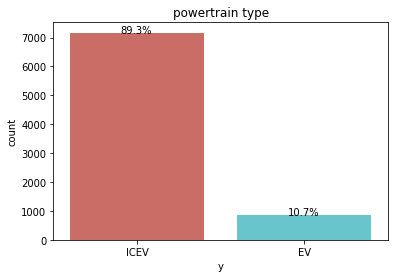

In [5]:
ax = sns.countplot(x='y', data=data, palette='hls')
ax.set(xticklabels=['ICEV','EV'])
plt.title('powertrain type')
total = ax.patches[0].get_height() + ax.patches[1].get_height()
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.3, p.get_height()+1))
plt.show(ax)

## Categorical Variables

Here we explore and summarize some of the categorical variables present in the survey data. The varibles to be chosen in the analysis were proven to be highly significant by earlier research (Jia, 2019, Li, 2020).

We note the following: the race variable indicates that the dataset is not represented of the california population. Each CA area zone is well represented in the data set (with some possible overrepresentation of the LA area); similarly, income distribution in the dataset appears to be relatively uniform. Finally, we note that most of the households in the data are single family households. However, we wish to highlight the fact that none of the imbalance seen here will pose a problem for the analysis conducted in this project, as it is a separate issue from the classs imbalance discussed in the previous section.

According to the Calfiornia Clean Vehicle Rebate (HOV decals for low emission vehicles), the ratio between female applicants and male applicants is 1/3, a relationship reflected in the "Vehicle Owner Gender" plot below. Furthermore, as one might expect, ride-hailing drivers appear less likely to own an EV, and the persence of workplace charging devices appear to encourage the purchase and use of an EV.

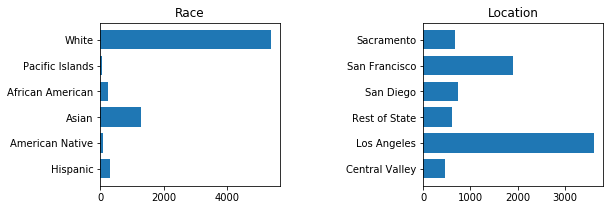

In [6]:
temp = data.copy()
temp.drop(temp[temp['region'] == 7].index, inplace=True)

data_column = [data.race,temp.region]
title = ['Race','Location']
yticklabels = [['Hispanic','American Native','Asian','African American','Pacific Islands','White'],
              ['Central Valley','Los Angeles','Rest of State','San Diego','San Francisco','Sacramento','NA']]
cat_plot(data_column,title,yticklabels)

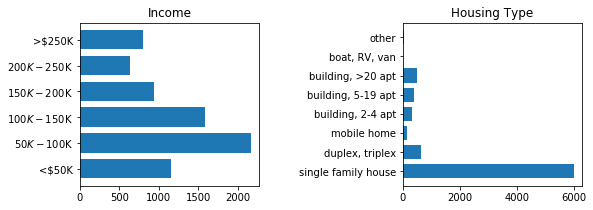

In [7]:
data_column = [data.hh_inc,data.housing]
title = ['Income','Housing Type']
yticklabels = [['<$50K','$50K-$100K','$100K-$150K','$150K-$200K','$200K-$250K','>$250K'],
              ['single family house','duplex, triplex','mobile home',
               'building, 2-4 apt','building, 5-19 apt','building, >20 apt',
               'boat, RV, van','other']]
cat_plot(data_column,title,yticklabels)

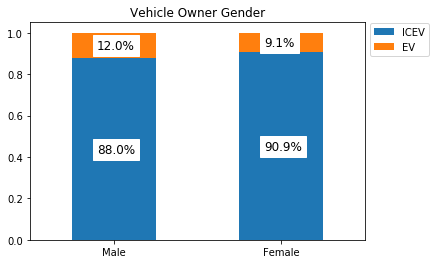

In [8]:
temp = data.copy()
temp.drop(temp[temp['gender'] == 3].index, inplace=True)
temp.drop(temp[temp['gender'] == 4].index, inplace=True)

cat_plot_y(temp,'gender','Vehicle Owner Gender',['Male', 'Female'],1,2)

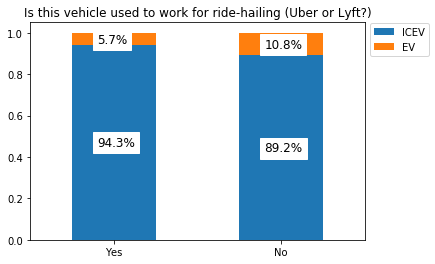

In [9]:
temp = data.copy()
temp = temp[temp['tnc_veh'].notnull()]

cat_plot_y(temp,'tnc_veh','Is this vehicle used to work for ride-hailing (Uber or Lyft?)',['Yes', 'No'],1,2)

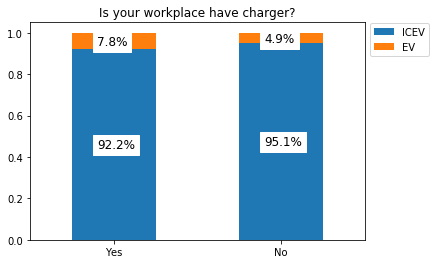

In [10]:
temp = data.copy()
temp.drop(temp[temp['charge_work'] == 3].index, inplace=True)
temp = temp[temp['charge_work'].notnull()]

cat_plot_y(temp,'charge_work','Is your workplace have charger?',['Yes', 'No'],1,2)

## Numerical Variables

Here we explore and summarize some of the quantitative variables present in the survey data. As seen in the summary statistics table for quantitative variables, the annual vehicle miles has a very different scale compared to the other variables (all representing counts). Thus, in further analysis we are careful to standardize the quantitative variables to ensure stable performance of classification models. 

As expected, the number of employeed household members, numer of household members with a driver license, and household size are highly correlated. We keep all these variables in our analysis, because all might be highly explanatory in the analysis, especially because it is possible for complex interations between these varibles to be indicative of households more likely to own an EV vehicle. 

After normalizing the histogram of annumal miles driven, we see most of the EV are driven about 12,000, a reasonable national average. Finally, we see a good spread of ICEV and EV among all house and fleed sizes. Surprisingly, there are many one-vehicle households with an EV.

In [11]:
print(data.shape)
data.loc[:,data.columns.isin(['ann_mile', 'hh_veh', 'hh_size','hh_emp','hh_drv'])].describe().round(2)

(8027, 21)


,ann_mile,hh_veh,hh_size,hh_emp,hh_drv
count,8012.00,8027.00,8027.00,8027.00,8027.00
mean,9805.62,2.45,2.59,2.22,2.10
std,12808.39,1.20,1.27,0.89,0.82
min,0.00,1.00,1.00,1.00,1.00
25%,4375.00,2.00,2.00,2.00,2.00
50%,8000.00,2.00,2.00,2.00,2.00
75%,12000.00,3.00,3.00,3.00,2.00
max,300000.00,8.00,16.00,9.00,6.00


__Variable dictionary:__

__ann_miles:__ annual vehicle miles (miles driven in the past year).

__hh_veh:__ number of vehicles in a household. from 1 to 8, with an average of 2.45.

__hh_size:__ number of people in a household. from 1 to 16, with an average of 2.59.

__hh_emp:__ number of employeed people in a household. from 1 to 6, with an average of 2.22

__hh_dvr:__ number of people with a driver license in a household. from 1 to 6, with an average of 2.10.

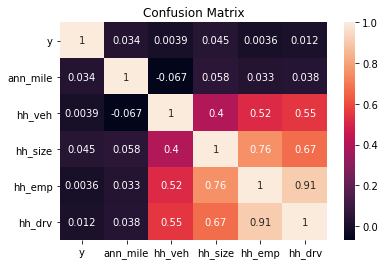

In [12]:
corrMatrix = data.loc[:,~data.columns.isin(['sampno'])].corr()
sns.heatmap(corrMatrix, annot=True)
plt.title('Confusion Matrix')
plt.show()

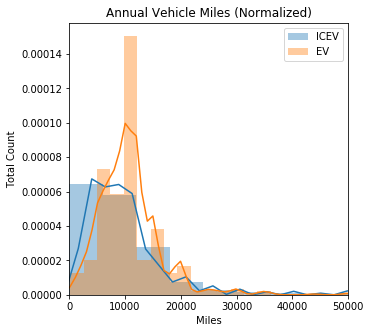

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
for group in data.y.unique():
    sns.distplot(data.loc[data.y == group, 'ann_mile'],ax=ax,label=group,norm_hist=True)

ax.set_xlabel('Miles')
ax.set_ylabel('Total Count')
ax.set_title('Annual Vehicle Miles (Normalized)')
plt.xlim(0, 50000)
ax.legend(labels=['ICEV','EV'])

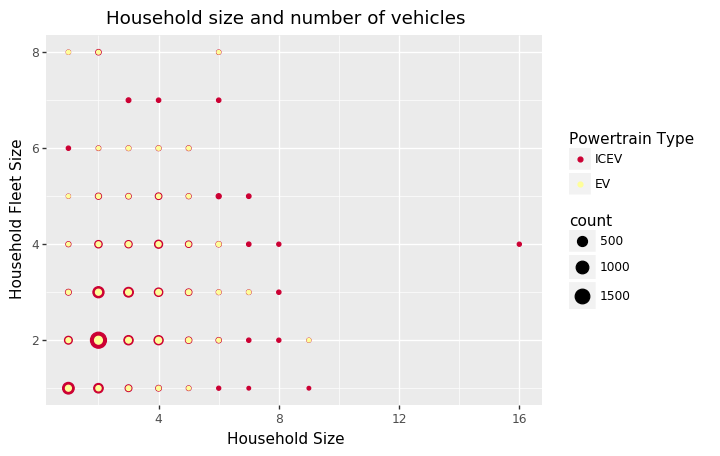

<ggplot: (-9223371949425689916)>


In [14]:
temp = data.copy()
temp['ones'] = 1
temp = temp.groupby(['hh_size','hh_veh','y'])['ones'].sum().to_frame('count').reset_index()
temp['y'] = temp['y'].astype('object')

p = (ggplot(temp) +
     geom_point(aes('hh_size','hh_veh', color='y', size='count')) +
     ggtitle("Household size and number of vehicles") +
     labs(x="Household Size", y="Household Fleet Size") +
     labs(colour="Powertrain Type") +
     scale_color_manual(labels = ["ICEV", "EV"], values = ["#CC0033","#FFFF99"])
    )
print(p)